# Business objective

This app predicts if an applicant will be approved for a credit card or not. Each time there is a hard enquiry your credit score is affected negatively. This app predict the probability of being approved without affecting your credit score. This app can be used by applicant who wants to find out if they will be approved for a credit card without affecting their credit score.

# 0. import the necessary packages

In [84]:
import numpy as np
import pandas as pd
# import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# from pandas.core.common import SettingWithCopyWarning
# from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
# import scikitplot as skplt
# from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
# import joblib
import os
%matplotlib inline

# 1. Get the data

## 1.1 import csv file

In [85]:
credit_app = pd.read_csv('Resources/application_record.csv')
credit_rec = pd.read_csv('Resources/credit_record.csv')

## 1.2 creating the target variable

In [86]:
month=pd.DataFrame(credit_rec.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=month.rename(columns={'MONTHS_BALANCE':'Account age'})

In [87]:
# Merge available data
complete_cred_data = pd.merge(credit_app, credit_rec, how='inner',on='ID')

In [19]:
# credit_rec['dep_value'] = None
# credit_rec['dep_value'][credit_rec['STATUS'] =='2']='Yes'
# credit_rec['dep_value'][credit_rec['STATUS'] =='3']='Yes'
# credit_rec['dep_value'][credit_rec['STATUS'] =='4']='Yes'
# credit_rec['dep_value'][credit_rec['STATUS'] =='5']='Yes'
# creunit=credit_rec.groupby('ID').count()
# creunit['dep_value'][creunit['dep_value'] > 0]='Yes'
# creunit['dep_value'][creunit['dep_value'] == 0]='No'
# creunit = creunit[['dep_value']]

In [23]:

# complete_credit_data = pd.merge(complete_cred_data,creunit,how='inner',on='ID')
# cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
# cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
# cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
# cc_data_full_data.drop('dep_value',axis=1,inplace=True)
# # pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

In [88]:
complete_cred_data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS'],
      dtype='object')

## 1.3 Rename features

In [89]:
# rename the features to a more readable feature names
renamed_credit_data = complete_cred_data.rename(columns={'CODE_GENDER':'Gender', 'FLAG_OWN_CAR':'Car Owner', 'FLAG_OWN_REALTY':'Owns a Property', 'CNT_CHILDREN':'No of Children',
       'AMT_INCOME_TOTAL':'Income', 'NAME_INCOME_TYPE':'Empolyed', 'NAME_EDUCATION_TYPE':'Level of Education',
       'NAME_FAMILY_STATUS':'Marital Status', 'NAME_HOUSING_TYPE':'Living Arrangement', 'DAYS_BIRTH':'Age',
       'DAYS_EMPLOYED':'length of Employment', 'FLAG_MOBIL':'mobile', 'FLAG_WORK_PHONE':'wkphone', 'FLAG_PHONE':'Has a Phone',
       'FLAG_EMAIL':'email', 'OCCUPATION_TYPE':'Job Title', 'CNT_FAM_MEMBERS':'No of family members', 'MONTHS_BALANCE':'total'})


## 1.4 Split the data into training and test sets, creating a copy of the datasets

In [91]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [92]:
credit_card_train_original, credit_card_test_original = data_split(renamed_credit_data, 0.2)

In [93]:
credit_card_train_original.shape

(622172, 20)

In [94]:
credit_card_test_original.shape

(155543, 20)

In [95]:
credit_card_train_original.to_csv('Resources/train.csv',index=False)

In [96]:
credit_card_test_original.to_csv('Resources/test.csv',index=False)

In [97]:
# creating a copy of the dataset so that the original stays untouched
credit_card_train_copy = credit_card_train_original.copy()
credit_card_test_copy = credit_card_test_original.copy()

# 2. Explore the Data

## 2.1 Quick glance at the data

In [98]:
renamed_credit_data.head()

,ID,Gender,Car Owner,Owns a Property,No of Children,Income,Empolyed,Level of Education,Marital Status,Living Arrangement,Age,length of Employment,mobile,wkphone,Has a Phone,email,Job Title,No of family members,total,STATUS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,0,C
1,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-1,C
2,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-2,C
3,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-3,C
4,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-4,C


In [99]:
renamed_credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    777715 non-null  int64  
 1   Gender                777715 non-null  object 
 2   Car Owner             777715 non-null  object 
 3   Owns a Property       777715 non-null  object 
 4   No of Children        777715 non-null  int64  
 5   Income                777715 non-null  float64
 6   Empolyed              777715 non-null  object 
 7   Level of Education    777715 non-null  object 
 8   Marital Status        777715 non-null  object 
 9   Living Arrangement    777715 non-null  object 
 10  Age                   777715 non-null  int64  
 11  length of Employment  777715 non-null  int64  
 12  mobile                777715 non-null  int64  
 13  wkphone               777715 non-null  int64  
 14  Has a Phone           777715 non-null  int64  
 15  

## 2.2 Functions used to explore each feature

In [100]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [38]:
# function to display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'Age':
            # change the feature to express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'length of Employment':
            # select only the rows where the rows are negative to ignore those who are retired or unemployed
            employment_length = credit_card_train_copy['length of Employment'][credit_card_train_copy['length of Employment'] < 0]
            employment_length_no_ret_yrs = np.abs(employment_length)/365.25
            print('Description:\n{}'.format((employment_length_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_length.dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))


In [40]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    match feature:
        case 'Living Arrangement' | 'Level of Education':
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

In [102]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'Marital status' | 'Living Arrangement' | 'Job title' | 'Employed' | 'level of Education':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [103]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'length of Employment':
            employment_len_no_ret = credit_card_train_copy['Length of Employment'][credit_card_train_copy['Length of Employment'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [104]:
credit_card_train_copy.shape

(622172, 20)

## 2.3 Univariate analysis

### 2.3.1. Gender

In [105]:
gen_info_feat(credit_card_train_copy,'Gender')

Description:
count     622172
unique         2
top            F
freq      415131
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
    Count  Frequency (%)
F  415131          66.72
M  207041          33.28


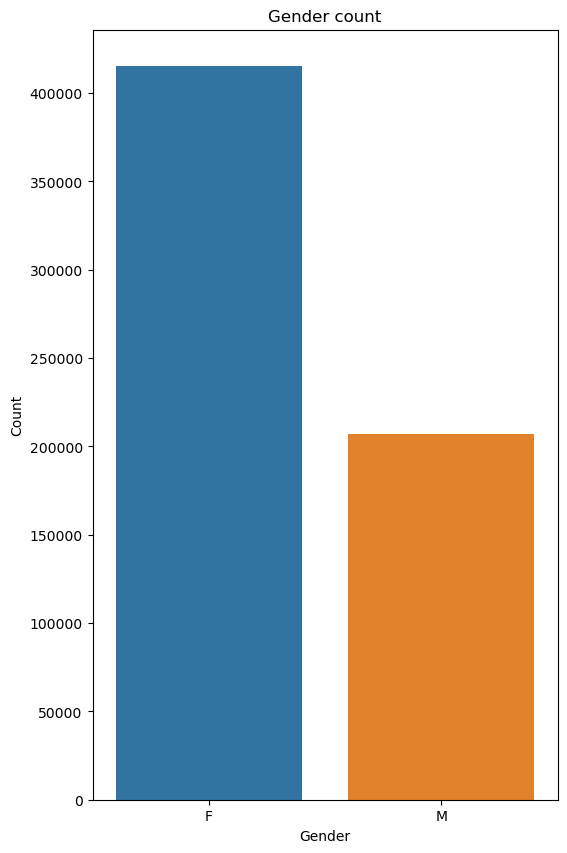

In [106]:
create_bar_plot(credit_card_train_copy,'Gender')

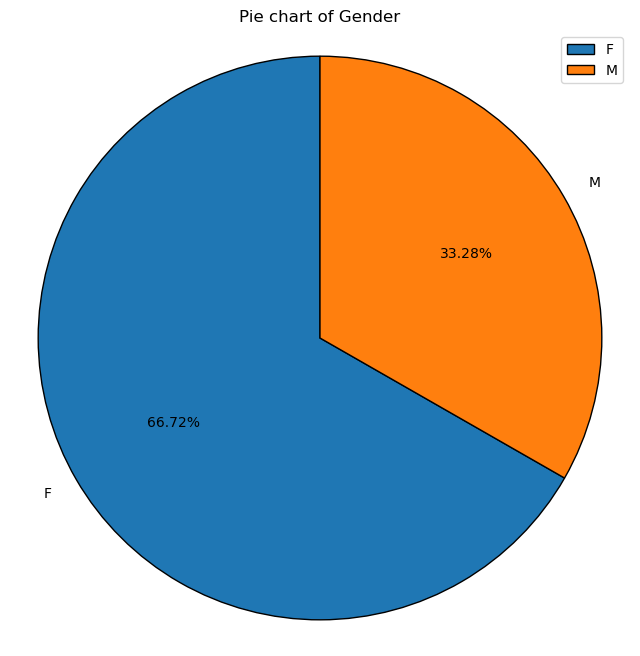

In [107]:
create_pie_plot(credit_card_train_copy,'Gender')

Interpretation:
- We have more female applicants than male (67% vs 32%)

### 2.3.2 Age

In [108]:
gen_info_feat(credit_card_train_copy,'Age')

Description:
count   622172.00
mean        44.14
std         11.24
min         20.50
25%         34.81
50%         43.13
75%         53.25
max         68.86
Name: Age, dtype: float64
**************************************************
Object type:int64


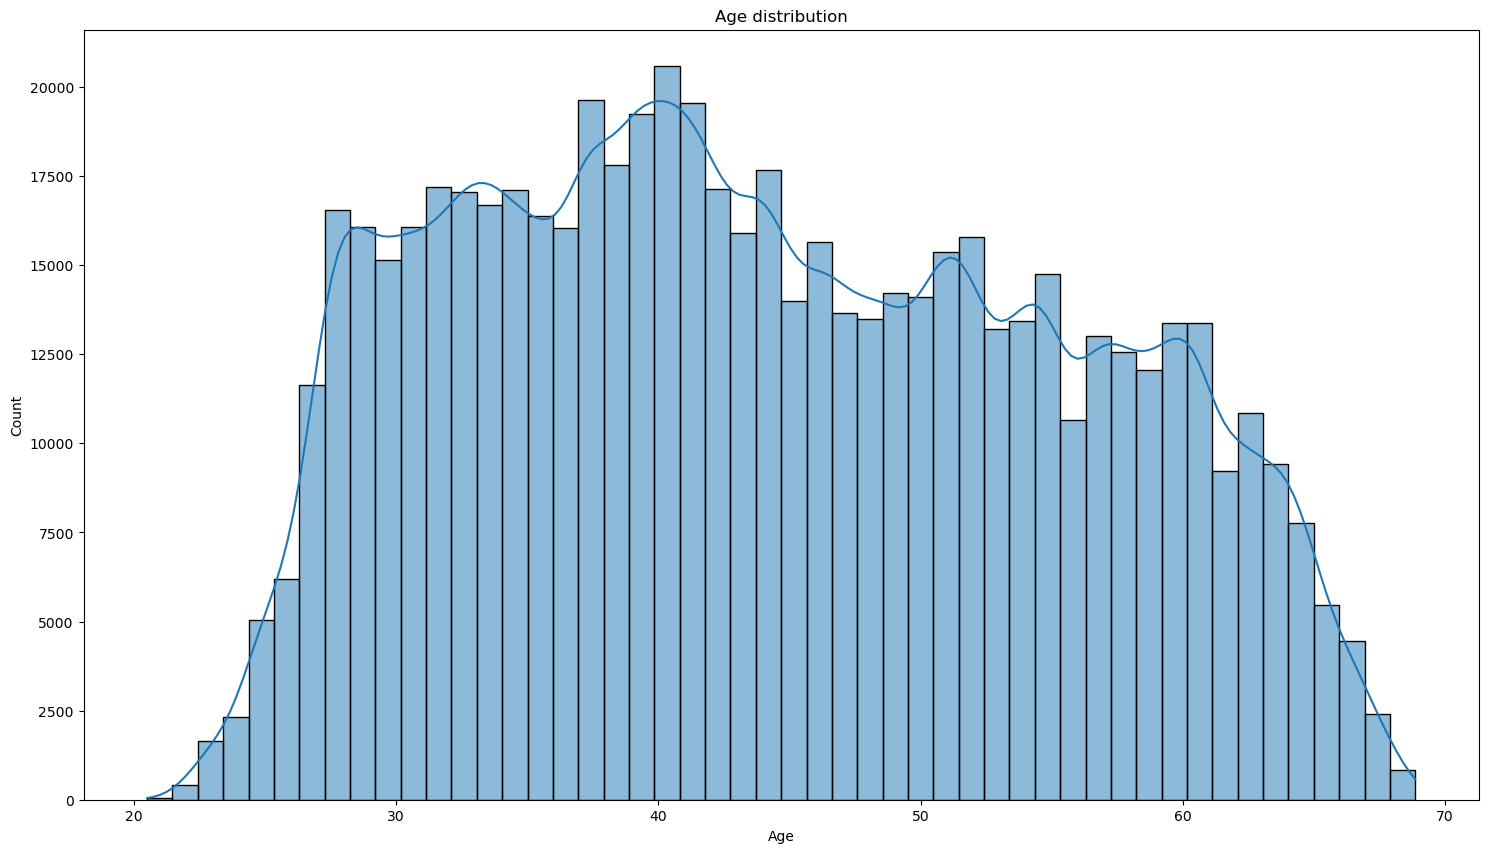

In [109]:
create_hist_plot(credit_card_train_copy,'Age')

* bivariate analysis with target variable

Interpretation:
- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants

### 2.3.3 Marital status

In [110]:
gen_info_feat(credit_card_train_copy,'Marital Status')

Description:
count      622172
unique          5
top       Married
freq       437158
Name: Marital Status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Married               437158          70.26
Single / not married   75597          12.15
Civil marriage         48291           7.76
Separated              36126           5.81
Widow                  25000           4.02


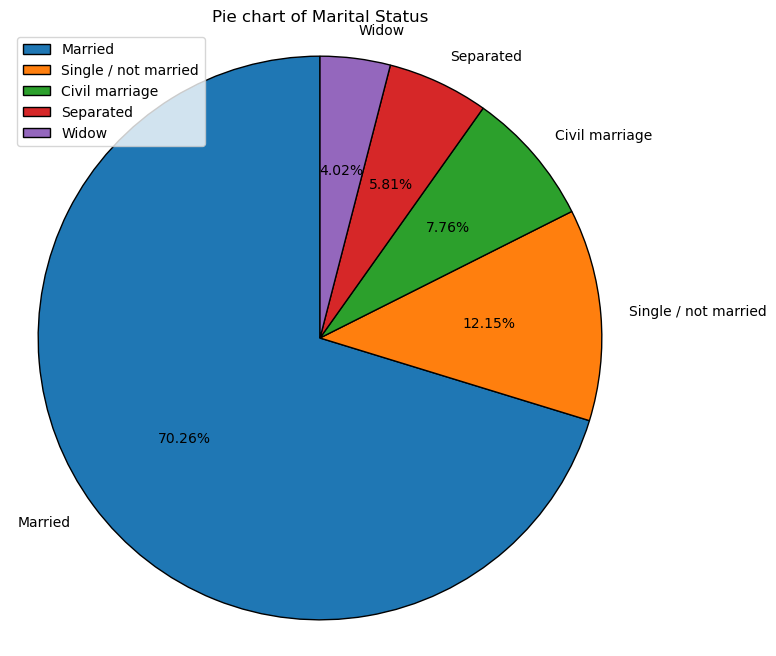

In [111]:
create_pie_plot(credit_card_train_copy,'Marital Status')

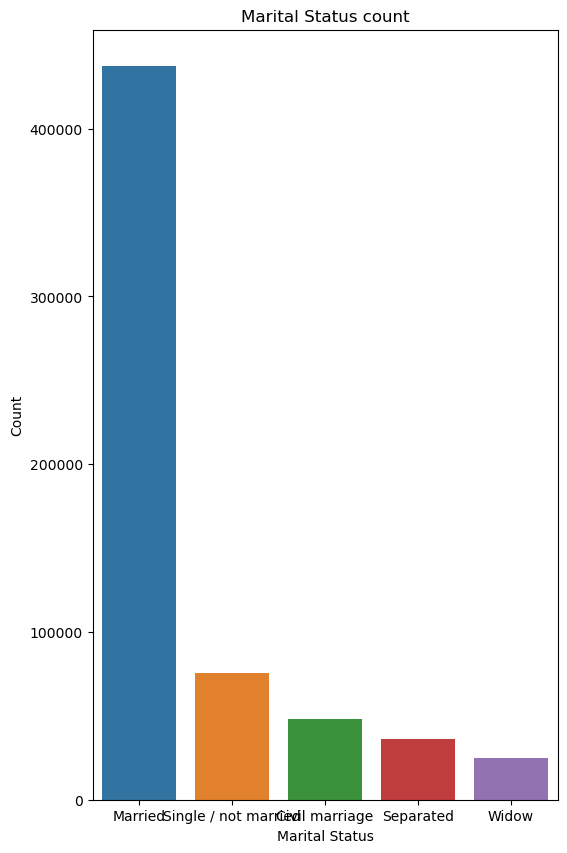

In [112]:
create_bar_plot(credit_card_train_copy,'Marital Status')

Interpretation:
- Most applicants are married
- Even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated.

### 2.3.4 Family member count

In [113]:
gen_info_feat(credit_card_train_copy,'No of family members')

Description:
count   622172.00
mean         2.21
std          0.91
min          1.00
25%          2.00
50%          2.00
75%          3.00
max         20.00
Name: No of family members, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
        Count  Frequency (%)
2.00   338862          54.46
1.00   113207          18.20
3.00   107919          17.35
4.00    53692           8.63
5.00     7228           1.16
6.00      926           0.15
7.00      214           0.03
15.00      82           0.01
9.00       38           0.01
20.00       4           0.00


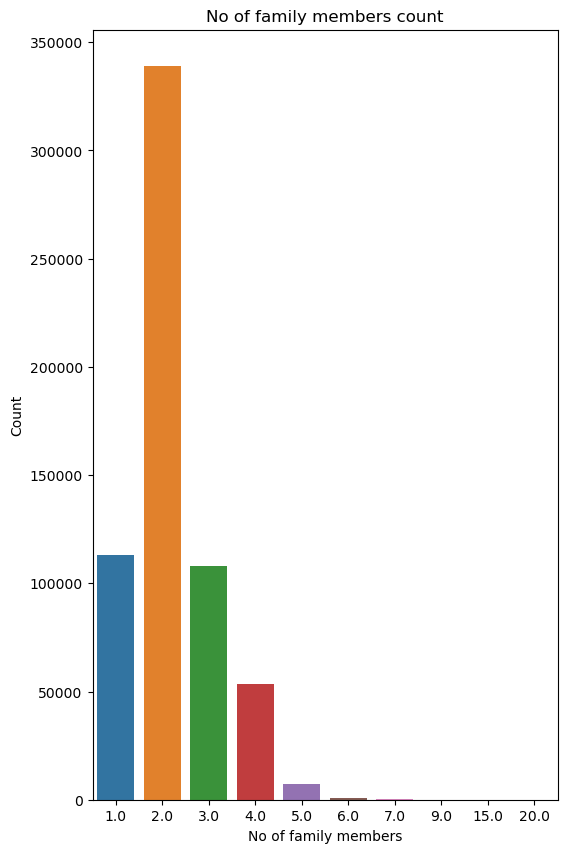

In [114]:
create_bar_plot(credit_card_train_copy,'No of family members')

Interpretation:
-   Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)
-   We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household


### 2.3.5 Children count

In [115]:
gen_info_feat(credit_card_train_copy,'No of Children')

Description:
count   622172.00
mean         0.43
std          0.74
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         19.00
Name: No of Children, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
     Count  Frequency (%)
0   432323          69.49
1   124603          20.03
2    56437           9.07
3     7486           1.20
4      944           0.15
5      255           0.04
14      82           0.01
7       38           0.01
19       4           0.00


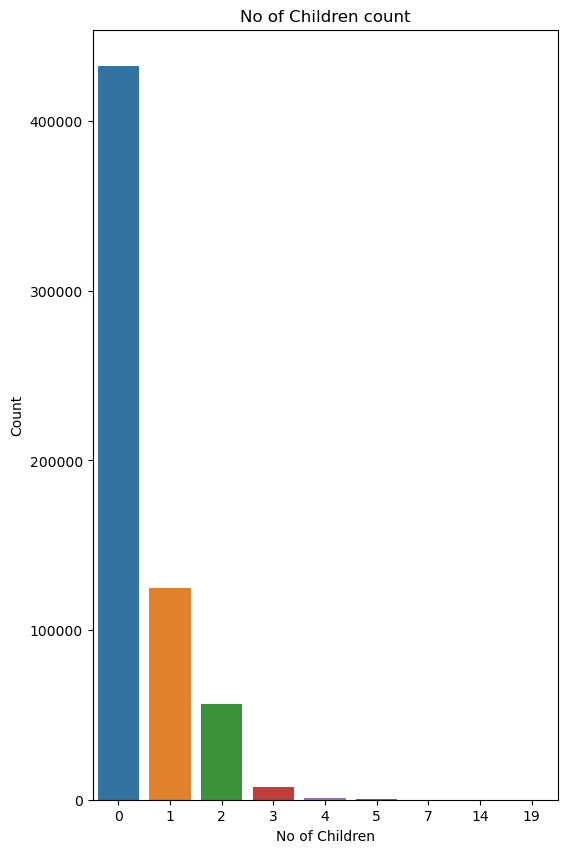

In [116]:
create_bar_plot(credit_card_train_copy,'No of Children')

Interpretation:
-	As previously discussed most applicant don’t have a child
-	Also here we have 6 outliers, probably the same from the family member count

### 2.3.6 Living Arrangement

In [117]:
gen_info_feat(credit_card_train_copy,'Living Arrangement')

Description:
count                622172
unique                    6
top       House / apartment
freq                 557851
Name: Living Arrangement, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
House / apartment    557851          89.66
With parents          28588           4.59
Municipal apartment   19647           3.16
Rented apartment       8697           1.40
Office apartment       4451           0.72
Co-op apartment        2938           0.47


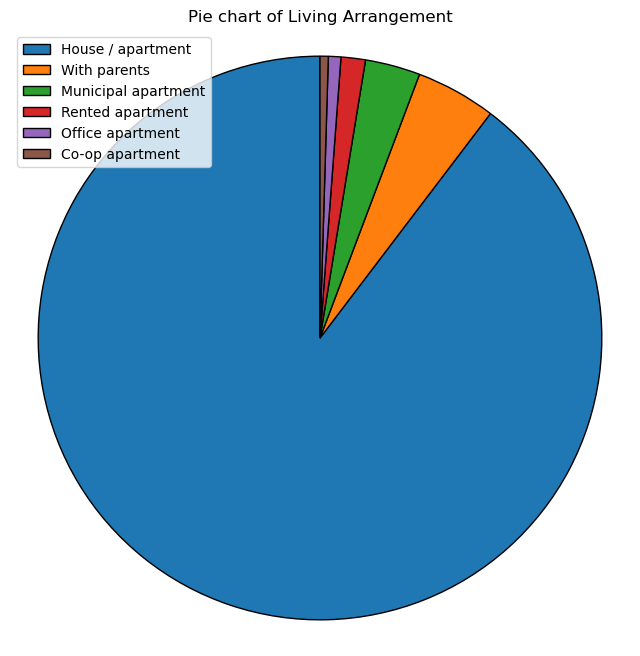

In [118]:
create_pie_plot(credit_card_train_copy,'Living Arrangement')

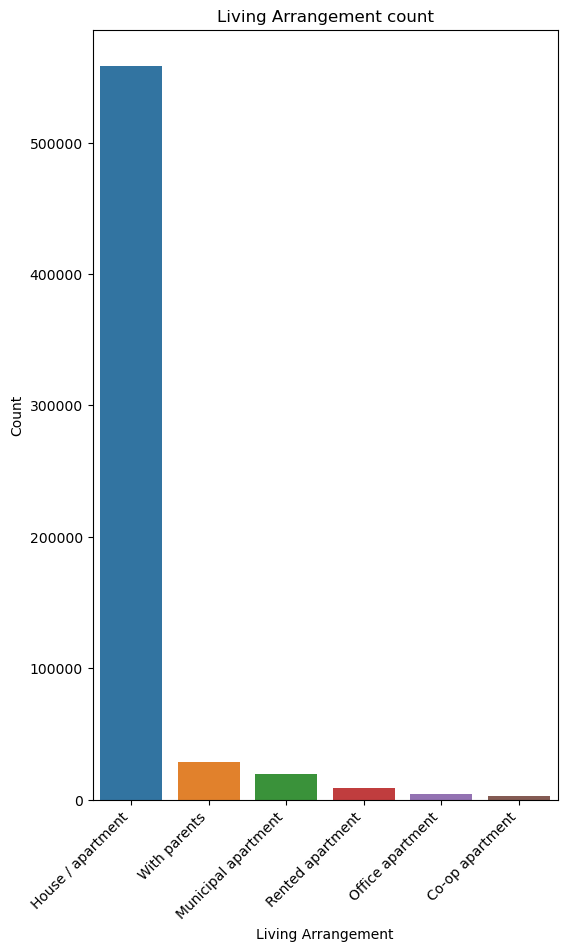

In [119]:
create_bar_plot(credit_card_train_copy,'Living Arrangement')

Interpretation:
- Almost every applicants live in house or apartment

### 2.3.7 Income

In [120]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(credit_card_train_copy,'Income')

Description:
count    622172.00
mean     188604.60
std      101798.34
min       27000.00
25%      121500.00
50%      162000.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
           Count  Frequency (%)
135000.00  72020          11.58
180000.00  54737           8.80
157500.00  50090           8.05
112500.00  49198           7.91
225000.00  49157           7.90
...          ...            ...
89550.00       3           0.00
594000.00      3           0.00
31950.00       2           0.00
134995.50      2           0.00
151200.00      1           0.00

[265 rows x 2 columns]


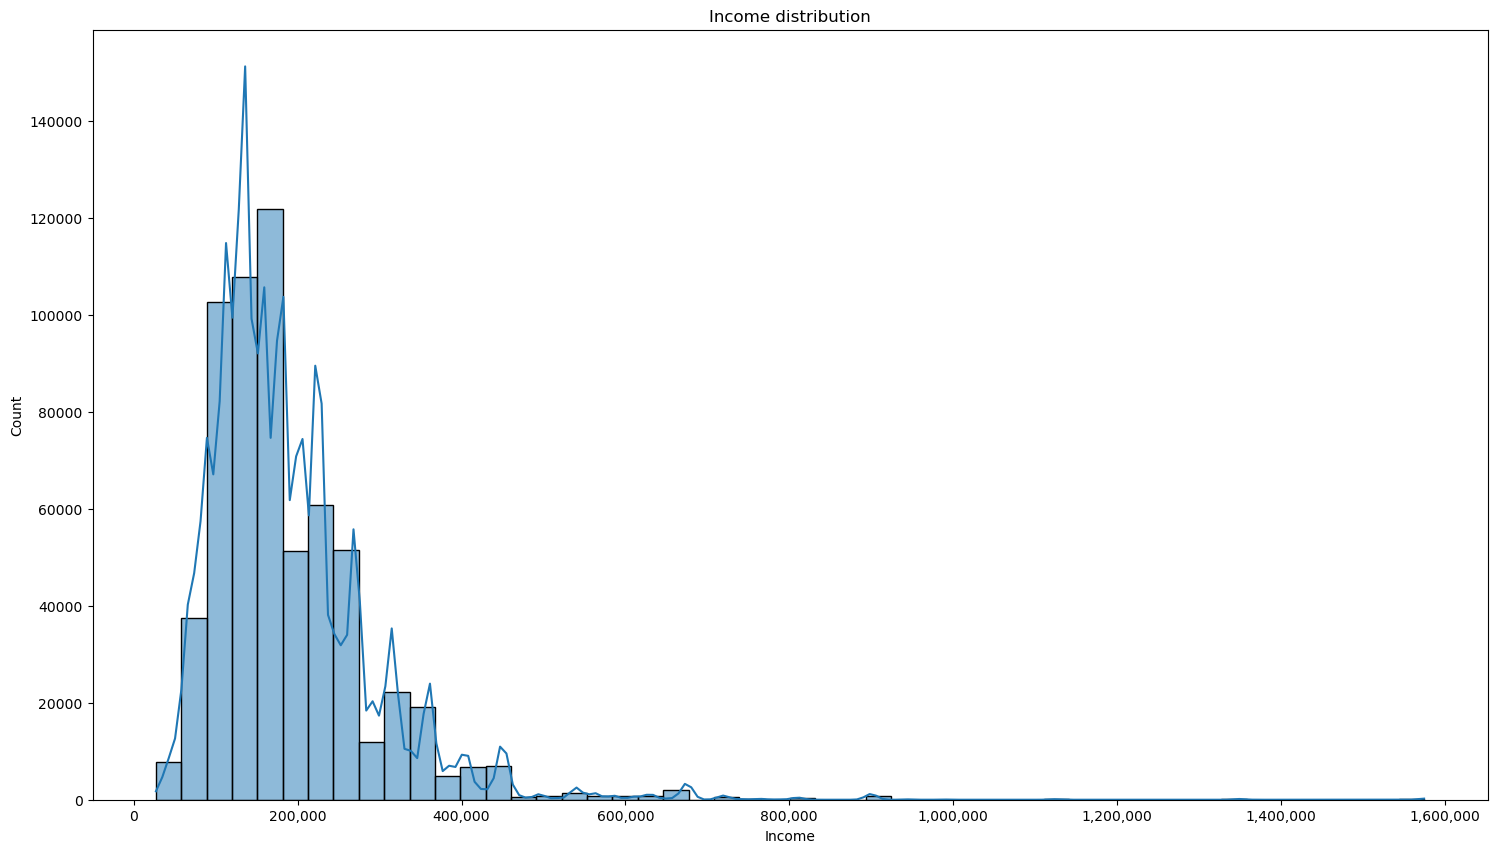

In [121]:
create_hist_plot(credit_card_train_copy,'Income')

* bivariate analysis with target variable

Interpretation:
-	The average income is 186890 but this amount accounts for outliers. If we ignore the outlier most people make 157500
-	We have 3 applicants who makes more than 1000000
-	This feature is positively skewed
-	High risk and low risk applicants have roughly similar income

### 2.3.8 Job title

In [122]:
gen_info_feat(credit_card_train_copy,'Job Title')

Description:
count       430144
unique          18
top       Laborers
freq        105172
Name: Job Title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                        Count  Frequency (%)
Laborers               105172          24.45
Core staff              61629          14.33
Sales staff             56397          13.11
Managers                54304          12.62
Drivers                 38015           8.84
High skill tech staff   25457           5.92
Accountants             21827           5.07
Medicine staff          21330           4.96
Cooking staff           10754           2.50
Security staff           9892           2.30
Cleaning staff           9095           2.11
Private service staff    5354           1.24
Low-skill Laborers       2929           0.68
Secretaries              2501           0.58
Waiters/barmen staff     2054           0.48
HR staff                 

In [123]:
job_title_nan_count = credit_card_train_copy['Job Title'].isna().sum()
job_title_nan_count

192028

In [124]:
rows_total_count = credit_card_train_copy.shape[0]

In [125]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.86 %


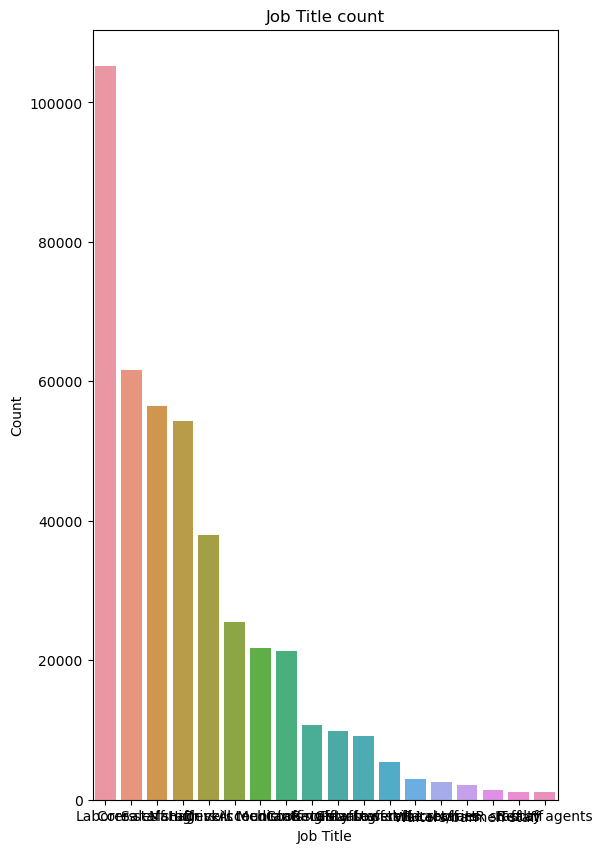

In [126]:
create_bar_plot(credit_card_train_copy,'Job Title')

Interpretation:
-	The most prolific Job title is laborers by far
-	We have 30.86% if missing data

### 2.3.11 Employment length

In [138]:
gen_info_feat(credit_card_train_copy,'length of Employment')

Description:
count   519825.00
mean         7.62
std          6.62
min          0.05
25%          2.87
50%          5.95
75%         10.08
max         43.02
Name: length of Employment, dtype: float64
**************************************************
Object type:int64


### 2.3.12 Has a car

In [140]:
gen_info_feat(credit_card_train_copy,'Car Owner')

Description:
count     622172
unique         2
top            N
freq      378675
Name: Car Owner, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
    Count  Frequency (%)
N  378675          60.86
Y  243497          39.14


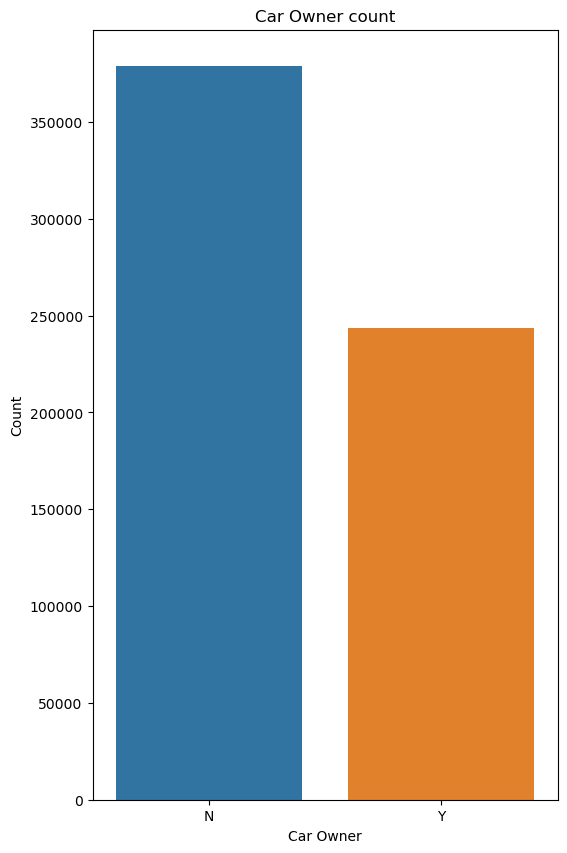

In [141]:
create_bar_plot(credit_card_train_copy,'Car Owner')

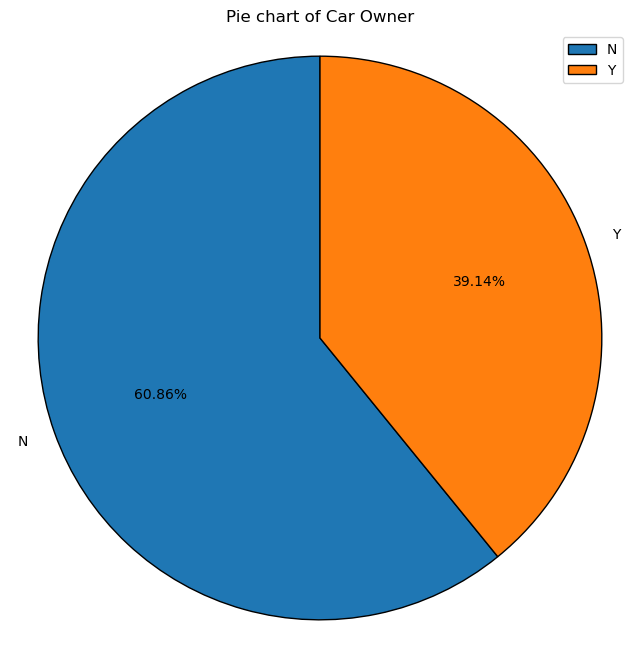

In [142]:
create_pie_plot(credit_card_train_copy,'Car Owner')

Interpretation:
- Most applicant don’t own a car

### 2.3.13 Has a property

In [143]:
gen_info_feat(credit_card_train_copy,'Owns a Property')

Description:
count     622172
unique         2
top            Y
freq      410338
Name: Owns a Property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
    Count  Frequency (%)
Y  410338          65.95
N  211834          34.05


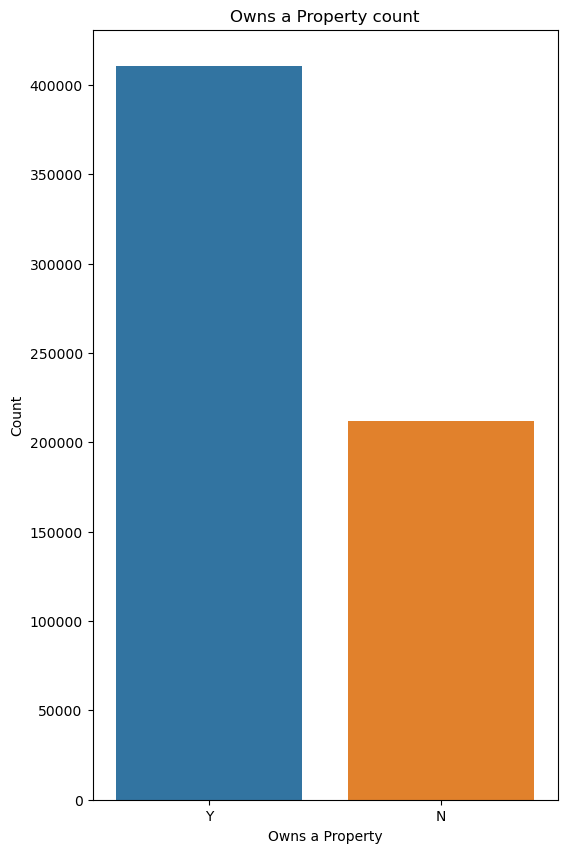

In [144]:
create_bar_plot(credit_card_train_copy,'Owns a Property')

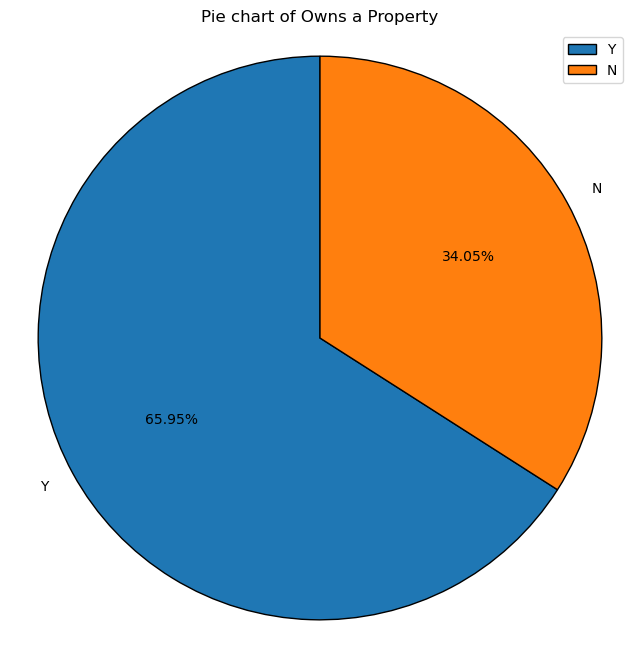

In [145]:
create_pie_plot(credit_card_train_copy,'Owns a Property')

Interpretation:
- Most applicants own a property

### 2.3.14 Has a work phone

In [147]:
gen_info_feat(credit_card_train_copy,'wkphone')

Description:
count   622172.00
mean         0.23
std          0.42
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: wkphone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0  477902          76.81
1  144270          23.19


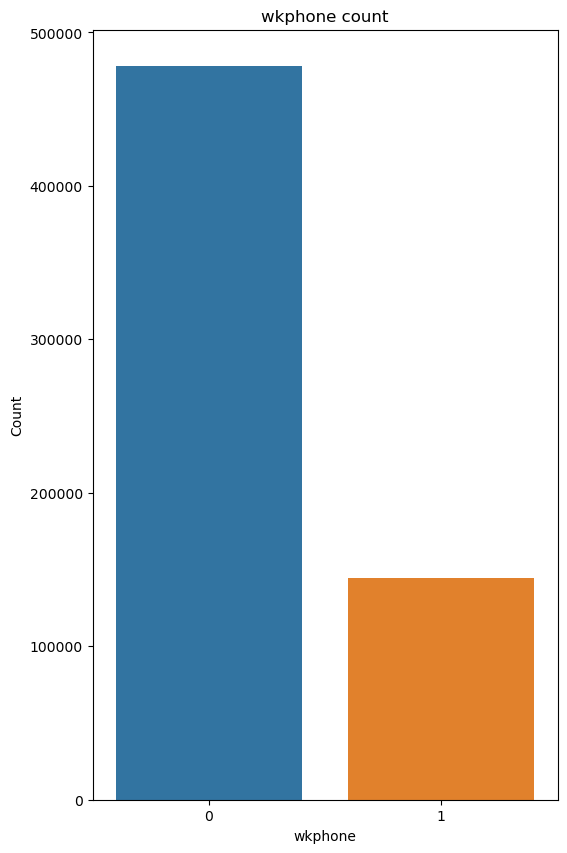

In [148]:
create_bar_plot(credit_card_train_copy,'wkphone')

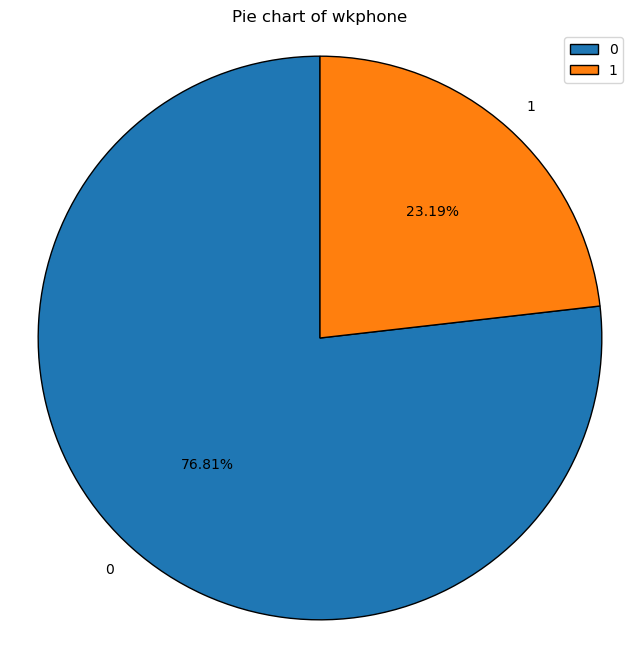

In [149]:
create_pie_plot(credit_card_train_copy,'wkphone')

Interpretation:
- More than ¾ of applicants don’t have a work phone

Note: Here 0 is no and 1 is yes

### 2.3.15 Has a mobile phone

In [150]:
gen_info_feat(credit_card_train_copy,'mobile')

Description:
count   622172.00
mean         1.00
std          0.00
min          1.00
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: mobile, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
1  622172         100.00


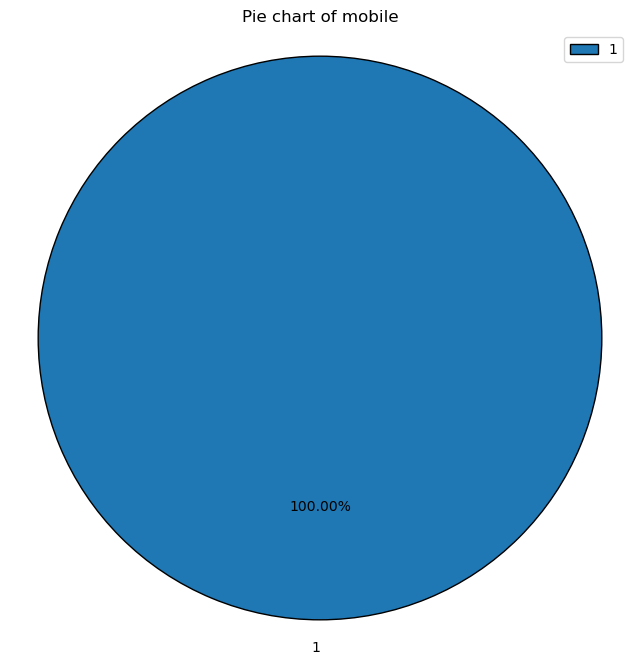

In [151]:
create_pie_plot(credit_card_train_copy,'mobile')

Interpretation:
- All the applicants without exception have a mobile phone

Note: Here 0 is no and 1 is yes

### 2.3.16 Has a phone

In [153]:
gen_info_feat(credit_card_train_copy,'Has a Phone')

Description:
count   622172.00
mean         0.30
std          0.46
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          1.00
Name: Has a Phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0  434796          69.88
1  187376          30.12


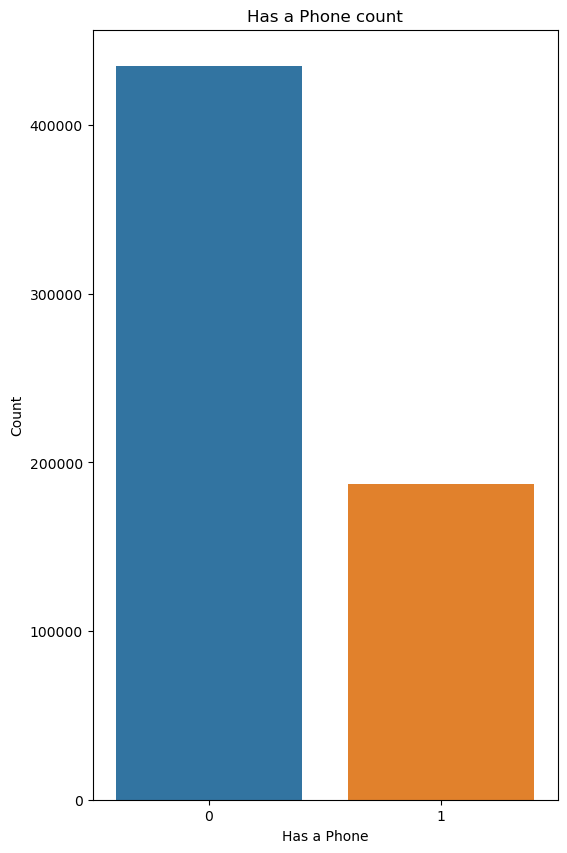

In [154]:
create_bar_plot(credit_card_train_copy,'Has a Phone')

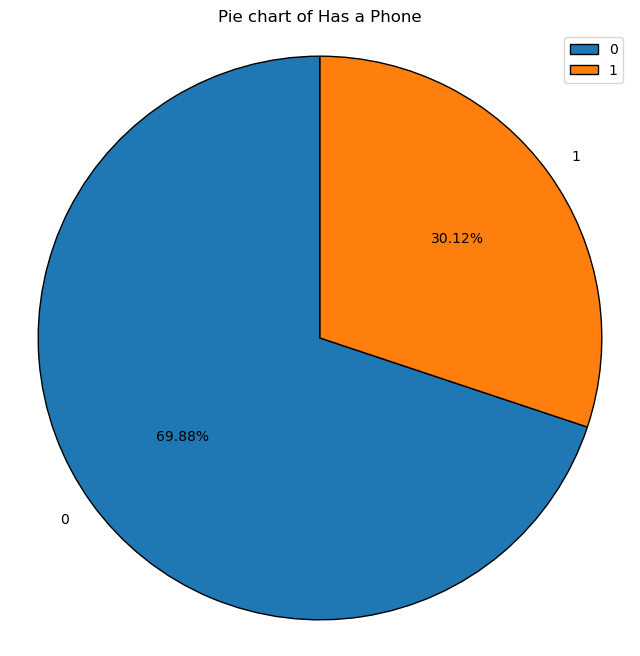

In [155]:
create_pie_plot(credit_card_train_copy,'Has a Phone')

Interpretation:
- Most applicants don’t have a phone (probably a home phone)

Note: Here 0 is no and 1 is yes

### 2.3.17 Has an email

In [156]:
gen_info_feat(credit_card_train_copy,'email')

Description:
count   622172.00
mean         0.09
std          0.29
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: email, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0  564808          90.78
1   57364           9.22


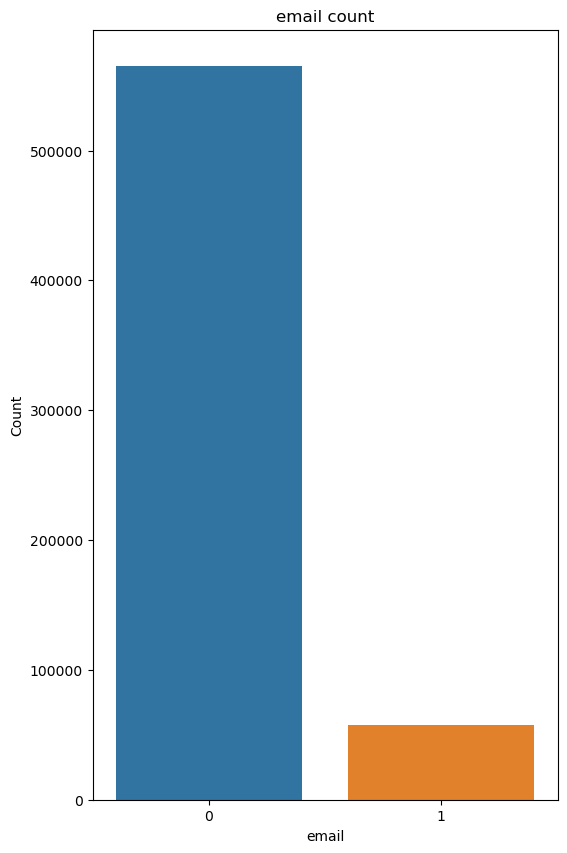

In [157]:
create_bar_plot(credit_card_train_copy,'email')

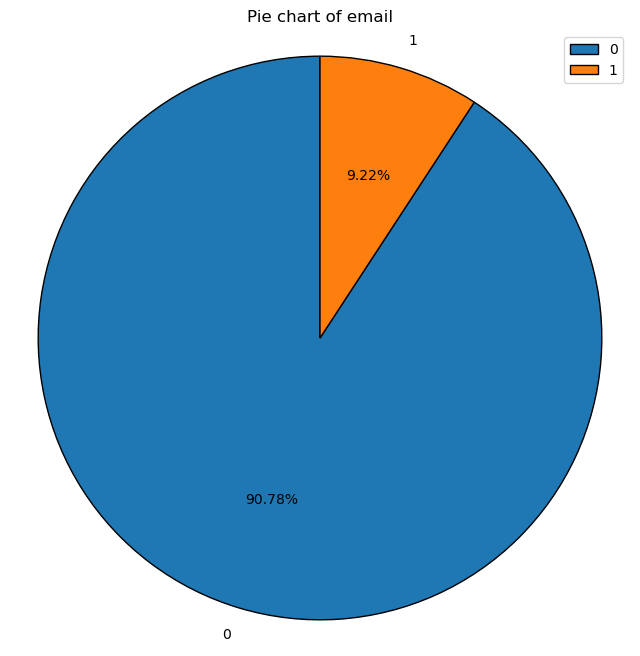

In [158]:
create_pie_plot(credit_card_train_copy,'email')

Interpretation:
- More than 90% of applicants don’t have an email

Note: Here 0 is no and 1 is yes

### 2.3.18 Account age

In [159]:
gen_info_feat(credit_card_train_copy,'STATUS')

Description:
count     622172
unique         8
top            C
freq      263310
Name: STATUS, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
    Count  Frequency (%)
C  263310          42.32
0  232651          37.39
X  116921          18.79
1    7004           1.13
5    1220           0.20
2     651           0.10
3     234           0.04
4     181           0.03


In [160]:
create_hist_plot(credit_card_train_copy,'STATUS', the_bins=30)

## 2.4 Bivariate analysis

### 2.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 2.4.1.1 Scatter plots

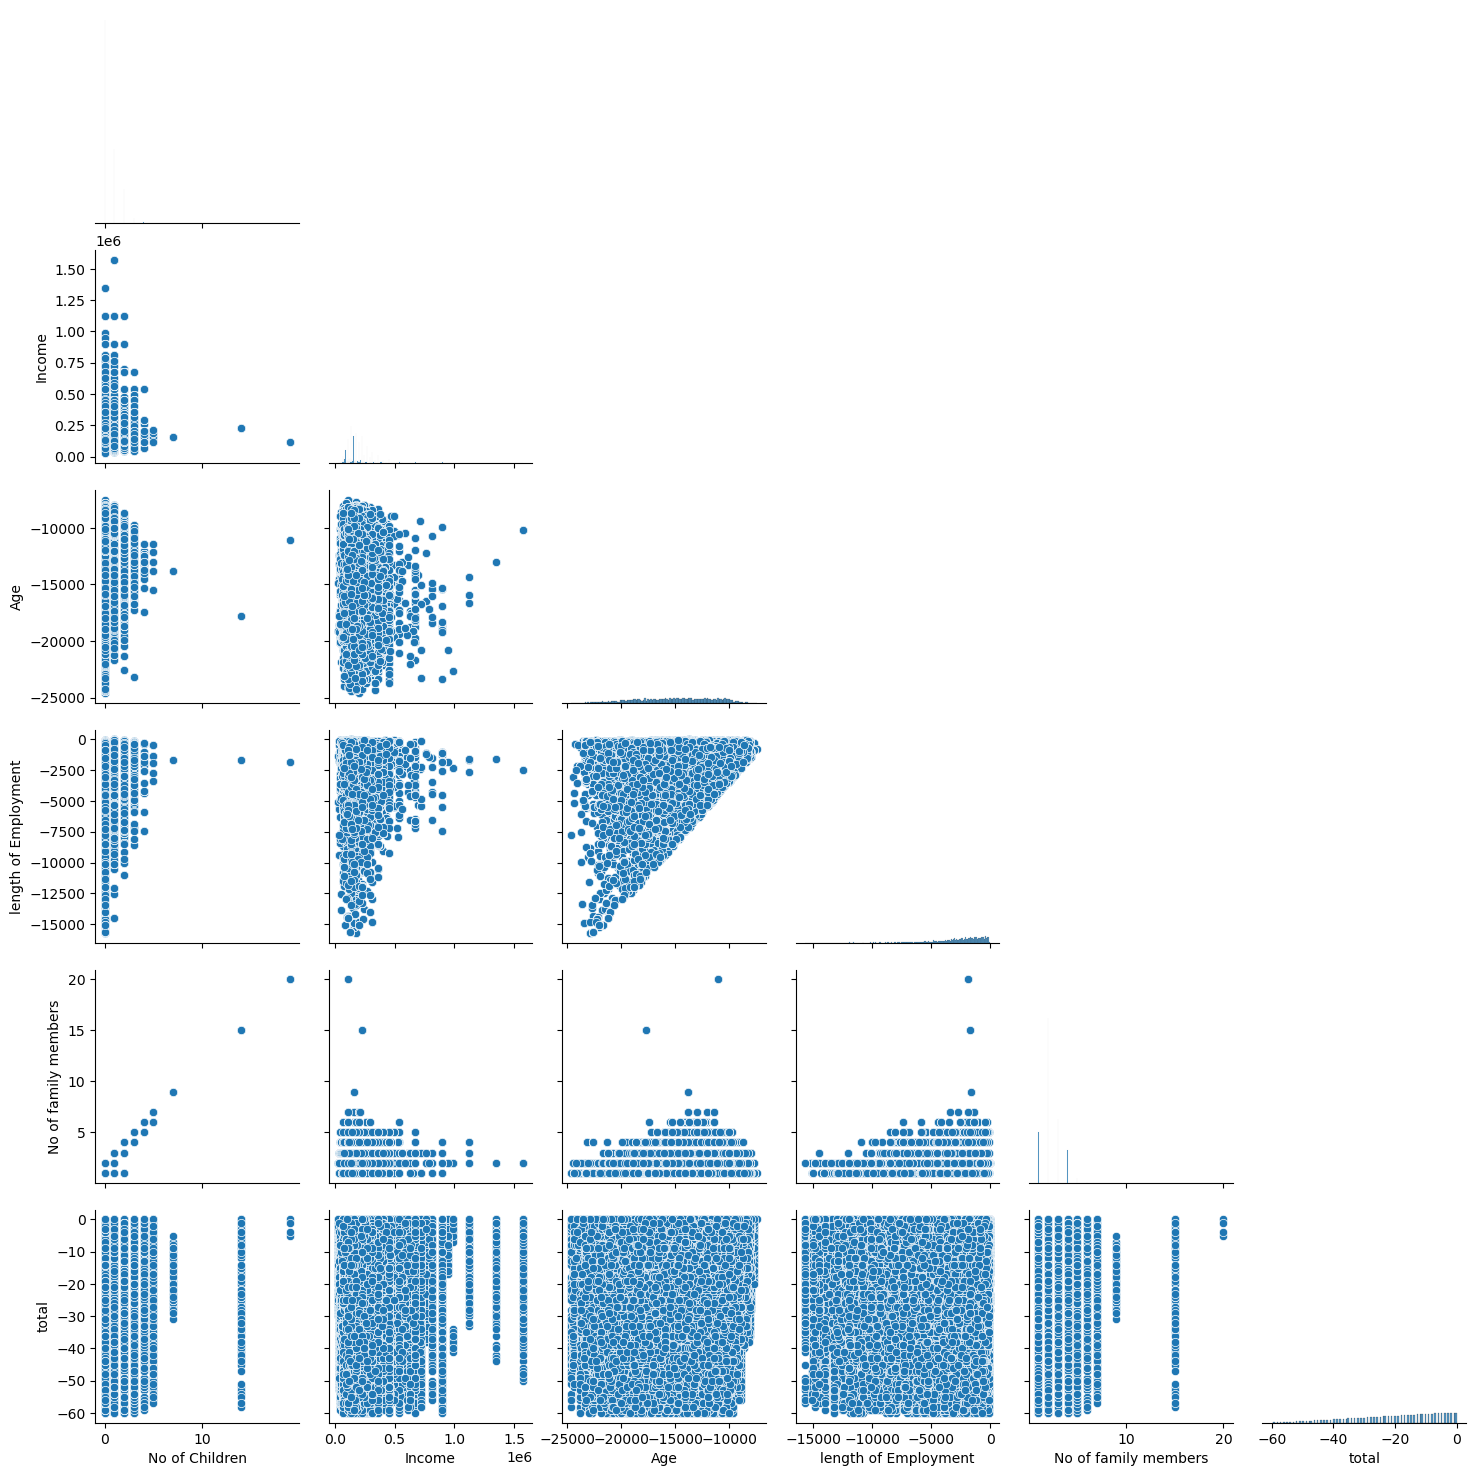

In [161]:
sns.pairplot(credit_card_train_copy[credit_card_train_copy['length of Employment'] < 0].drop(['ID','mobile', 'wkphone', 'Has a Phone', 'email'],axis=1),corner=True)
plt.show()

Interpretation:
- We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem. Meaning that the features are highly correlated. We will need to drop one of them.
- Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

## 3.5 Data Preprocessing

In [111]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

## 4.1 Models training

In [116]:
classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'support_vector_machine':SVC(random_state=42,probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [ ]:
Logistic Regression
k-Nearest Neighbors
Decision Trees